# Generate all Heatmaps (Occlusion of GradCam) for a given Version

Generates a PDF with all heatmaps for a given version.

- Choose heatmap type (Occlusion or GradCam)
- Choose if heatmaps should be genereated or loaded
- Choose if pictures (mean over all axis, highest heatmap value slice, original image) should be generated or loaded
- Choose if all patients should be used or only wrongly classified ones  
  

  
- Define if only the predicted class should be visualized (default: predicted class)
- Define if only last gradcam layer should be visualized (default: last layer)

## Load Libraries and Modules

In [1]:
!pip install tqdm
!pip install seaborn
!pip install fpdf2

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
%matplotlib inline

import os
import h5py
import numpy as np
import pandas as pd
import gc as gci

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from fpdf import FPDF

from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc

import tensorflow as tf
from tensorflow import keras

print("TF  Version",tf.__version__)

TF  Version 2.4.0


In [3]:
# check and set path before loading modules
print(os.getcwd())
DIR = "/tf/notebooks/brdd/xAI_stroke_3d/"
if os.getcwd() != DIR:
    os.chdir(DIR)
    
import functions_metrics as fm
import functions_read_data as rdat
import functions_model_definition as md
import functions_gradcam as gc
import functions_occlusion as oc
import functions_plot_heatmap as phm

/tf


## Load Data and Define Parameters

In [4]:
# Define the path + output path:
print(os.getcwd())
DATA_DIR = DIR + "data/"

version = "10Fold_sigmoid_V0" # one of:
# 10Fold_sigmoid_V0, 10Fold_sigmoid_V1, 10Fold_sigmoid_V2, 10Fold_sigmoid_V2f, 10Fold_sigmoid_V3
# 10Fold_softmax_V0, 10Fold_softmax_V1, andrea
generate_heatmap_and_save = False # should the heatmap be generated and saved (else loaded)
generate_pictures = False # should the pictures be generated (else loaded)
only_wrong_out = True # should the generated pdf only contain the wrong predictions (else all)

hm_type = "gc" # gc or oc => gradcam or occlusion

pred_hm_only = False # if true heatmap of prediction will be generated else positive and negative heatmaps are shown
last_layer_only = True # Default = True, only last layer will be used for gradcam else once last and once all layers 

# Define Model Version
model_version = 1

# define paths
WEIGHT_DIR, DATA_OUTPUT_DIR, PIC_OUTPUT_DIR, pic_save_name = rdat.dir_setup(
    DIR, version, model_version, 
    hm_type = hm_type, ending = "_predcl" if pred_hm_only else "_bothcl")

/tf/notebooks/brdd/xAI_stroke_3d


In [5]:
## load images and ids
(X_in, pat, id_tab, all_results, num_models) = rdat.version_setup(
    DATA_DIR = DATA_DIR, version = version, model_version = model_version)

## load patient data
PAT_CSV_DIR = "/tf/notebooks/hezo/stroke_zurich/data/baseline_data_zurich_prepared0.csv" 
pat_dat = pd.read_csv(PAT_CSV_DIR, sep=";")


## Model

In [6]:
# define model
(input_dim, output_dim, LOSS, layer_connection, last_activation) = md.model_setup(version)

model_3d = md.stroke_binary_3d(input_dim = input_dim,
                               output_dim = output_dim,
                               layer_connection = layer_connection,
                               last_activation = last_activation)
model_3d.compile(
    loss=LOSS,
    optimizer=keras.optimizers.Adam(learning_rate=5*1e-5),
    metrics=["acc", tf.keras.metrics.AUC()]
)

# define if print should be enabled
check_print = True


In [7]:
# Define Model Name
generate_model_name = md.set_generate_model_name(
    model_version = model_version, 
    layer_connection = layer_connection, 
    last_activation = last_activation, 
    path = WEIGHT_DIR) 

# Plot GradCams

## Calculate Heatmap and Heatmap Uncertainty

In [8]:
# select all patients
p_ids = all_results["p_id"].to_numpy()

if version == "andrea":
    (res_table, res_images, res_model_names) = gc.get_img_and_models(
        p_ids, results = all_results[all_results.test_split == 6], pats = pat, imgs = X_in,
        gen_model_name = generate_model_name) # andrea split
elif version.startswith("10Fold"):
    (res_table, res_images, res_model_names) = gc.get_img_and_models(
        p_ids, results = all_results, pats = pat, imgs = X_in,
        gen_model_name = generate_model_name,
        num_models = num_models) # 10 Fold

In [9]:
vis_layers = [i.name for i in model_3d.layers[1:-6]]
vis_layers = [vis_layer for vis_layer in vis_layers if vis_layer.startswith("conv")]
print(vis_layers)

['conv3d', 'conv3d_1', 'conv3d_2', 'conv3d_3']


In [10]:
res_table

,index,p_idx,p_id,mrs,unfavorable,fold0,fold1,fold2,fold3,fold4,...,y_pred_model_2,y_pred_model_3,y_pred_model_4,y_pred_linear_avg,y_pred_trafo_avg,threshold,y_pred_class,y_pred_std,y_pred_unc,pred_correct
0,205,1,1,1.0,0,val,train,train,train,train,...,0.006181,0.013081,0.010683,0.014991,0.012591,0.225491,0,0.011203,0.023237,True
1,206,2,2,1.0,0,val,train,train,train,train,...,0.024134,0.049767,0.028247,0.041919,0.037599,0.225491,0,0.023930,0.066490,True
2,367,3,3,0.0,0,train,train,train,train,val,...,0.131908,0.243230,0.315786,0.214386,0.204826,0.225491,0,0.080713,0.259467,True
3,41,4,5,0.0,0,train,test,train,train,train,...,0.716669,0.567527,0.606706,0.632576,0.635252,0.225491,1,0.073403,0.234623,False
4,246,5,6,3.0,1,train,val,train,train,train,...,0.245842,0.348741,0.214166,0.255132,0.251216,0.225491,1,0.062966,0.199155,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
402,81,403,555,0.0,0,train,test,train,train,train,...,0.149244,0.191791,0.250303,0.174730,0.170676,0.225491,0,0.048965,0.151572,True
403,122,404,556,0.0,0,train,train,test,train,train,...,0.005016,0.002759,0.005417,0.005433,0.004173,0.225491,0,0.004365,0.000000,True
404,406,405,557,1.0,0,train,train,train,train,val,...,0.017060,0.018309,0.032593,0.021798,0.021210,0.225491,0,0.006236,0.006357,True
405,366,406,559,1.0,0,train,train,train,val,train,...,0.382259,0.497347,0.451662,0.383475,0.379759,0.225491,1,0.094122,0.305038,False


Loop over all patients and generate heatmaps.

In [11]:
# lc = last conv layer
# ac = average over all conv layer

if pred_hm_only:
    gcpp_hm = "last" # gc
    both_directions = False # oc
    cmap = "jet" # both
    hm_positive=True # both
else:
    gcpp_hm = "none" # gc
    both_directions = True # oc
    cmap = "bwr" # both
    hm_positive=False # both
    
if "sigmoid" in version or "andrea_split" in version:
    pred_idx = 0
elif "softmax" in version:
    pred_idx = 1
    
occ_size = (14, 14, 10)
occ_stride = 6
num_occlusion =  int(np.prod(((np.array(res_images.shape[1:4]) - occ_size) / occ_stride) + 1))
print('number of occlusions per model: ', num_occlusion)

if generate_heatmap_and_save:

    heatmaps_lc = []
    max_hm_slices_lc = []
    hm_mean_stds_lc = []

    heatmaps_ac = []
    max_hm_slices_ac = []
    hm_mean_stds_ac = []

    resized_imgs = []

    model_mode = "mean"
    for i in tqdm(range(len(res_table))):
        
        # define if and how heatmap should be inverted
        if pred_hm_only and hm_type == "gc":
            invert_hm = "all" if res_table.y_pred_class[i] == 0 else "none"
        elif not pred_hm_only and hm_type == "gc":
            invert_hm = "none"
        elif pred_hm_only and hm_type == "oc":
            invert_hm = "pred_class"
        elif not pred_hm_only and hm_type == "oc":
            invert_hm = "never"

        if hm_type == "gc":
            heatmap, resized_img, max_hm_slice, hm_mean_std = gc.multi_models_grad_cam_3d(
                img = res_images[i:i+1], 
                model_names = res_model_names[i],
                cnn = model_3d,
                layers = vis_layers[-1],
                model_mode = model_mode,
                pred_index = pred_idx,
                invert_hm = invert_hm,
                gcpp_hm = gcpp_hm)
        elif hm_type == "oc":
            heatmap, resized_img, max_hm_slice, hm_mean_std =  oc.volume_occlusion(
                volume = res_images[i:i+1], 
                model_names = res_model_names[i],
                res_tab = res_table[i:i+1].reset_index(drop = True),
                cnn = model_3d,
                occlusion_size = np.array(occ_size), 
                occlusion_stride = occ_stride,
                both_directions = both_directions,
                invert_hm = invert_hm)
            
        heatmaps_lc.append(heatmap)
        max_hm_slices_lc.append(max_hm_slice)
        hm_mean_stds_lc.append(hm_mean_std)

        if not last_layer_only and hm_type == "gc":
            heatmap, resized_img, max_hm_slice, hm_mean_std = gc.multi_models_grad_cam_3d(
            img = res_images[i:i+1], 
            cnn = model_3d,
            model_names = res_model_names[i],
            layers = vis_layers,
            model_mode = model_mode,
            pred_index = pred_idx,
            invert_hm = invert_hm,
            gcpp_hm = gcpp_hm)

            heatmaps_ac.append(heatmap)
            max_hm_slices_ac.append(max_hm_slice)
            hm_mean_stds_ac.append(hm_mean_std)

        resized_imgs.append(resized_img)
        
        gci.collect()        
        
else:
    res_table = pd.read_csv(DATA_OUTPUT_DIR + "all_tab_results_hm_unc_" + pic_save_name + ".csv",  sep = ",")
    heatmaps_lc = np.load(DATA_OUTPUT_DIR + "all_heatmaps_" + pic_save_name + ".npy")
    max_hm_slices_lc = np.load(DATA_OUTPUT_DIR + "all_max_activation_indices_" + pic_save_name + ".npy")
    if not last_layer_only and hm_type == "gc":
        heatmaps_ac = np.load(DATA_OUTPUT_DIR + "all_heatmaps_average_conv_layer_" + pic_save_name + ".npy")
        max_hm_slices_ac = np.load(DATA_OUTPUT_DIR + "all_max_activation_indices_laverage_conv_layer_" + pic_save_name + ".npy")
    

number of occlusions per model:  1600


In [12]:
if generate_heatmap_and_save:   
    res_table["heatmap_std_last_layer"] = hm_mean_stds_lc
    res_table["heatmap_unc_last_layer"] = (res_table["heatmap_std_last_layer"] - res_table.heatmap_std_last_layer.min()) / (
        res_table.heatmap_std_last_layer.max() - res_table.heatmap_std_last_layer.min())
    
    if not last_layer_only:
        res_table["heatmap_std_avg_layer"] = hm_mean_stds_ac
        res_table["heatmap_unc_avg_layer"] = (res_table["heatmap_std_avg_layer"] - res_table.heatmap_std_avg_layer.min()) / (
            res_table.heatmap_std_avg_layer.max() - res_table.heatmap_std_avg_layer.min())


#### Evaluate Metrics

Calculate heatmap uncertainty. Which is the normalized (min-max) averaged standard deviation over each pixel. 

In [13]:
if not last_layer_only and hm_type == "gc":
    print(np.corrcoef(res_table["heatmap_unc_avg_layer"], res_table["heatmap_unc_last_layer"]))
    print(np.corrcoef(res_table["y_pred_unc"], res_table["heatmap_unc_avg_layer"]))
print(np.corrcoef(res_table["y_pred_unc"], res_table["heatmap_unc_last_layer"]))

[[1.         0.53673418]
 [0.53673418 1.        ]]


[Text(0.5, 0, 'true class'), Text(0, 0.5, 'heatmap uncertainty')]

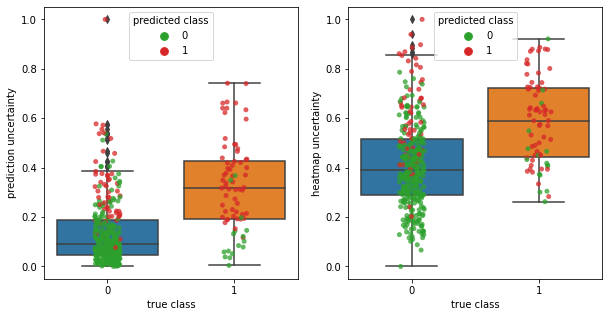

In [14]:
if not last_layer_only and hm_type == "gc":
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15, 5))
else:
    fig, (ax1, ax3) = plt.subplots(1,2, figsize = (10, 5))

sns.boxplot(x = "unfavorable",
    y = "y_pred_unc",
    data = res_table,
    ax = ax1)
sns.stripplot(x = "unfavorable",
    y = "y_pred_unc",
    hue = 'y_pred_class',
    alpha = 0.75,
    palette=["C2", "C3"],
    data = res_table,
    ax = ax1)
ax1.legend(title='predicted class', loc='upper center')
ax1.set(xlabel='true class', ylabel='prediction uncertainty')

if not last_layer_only:
    sns.boxplot(x = "unfavorable",
        y = "heatmap_unc_avg_layer",
        data = res_table,
        ax = ax2)
    sns.stripplot(x = "unfavorable",
        y = "heatmap_unc_avg_layer",
        hue = 'y_pred_class',
        alpha = 0.75,
        palette=["C2", "C3"],
        data = res_table,
        ax = ax2)
    ax2.legend(title='predicted class', loc='upper center')
    ax2.set(xlabel='true class', ylabel='heatmap uncertainty avg layer')

sns.boxplot(x = "unfavorable",
    y = "heatmap_unc_last_layer",
    data = res_table,
    ax = ax3)
sns.stripplot(x = "unfavorable",
    y = "heatmap_unc_last_layer",
    hue = 'y_pred_class',
    alpha = 0.75,
    palette=["C2", "C3"],
    data = res_table,
    ax = ax3)
ax3.legend(title='predicted class', loc='upper center')
ax3.set(xlabel='true class', ylabel='heatmap uncertainty')

<AxesSubplot:xlabel='heatmap_unc_last_layer', ylabel='y_pred_unc'>

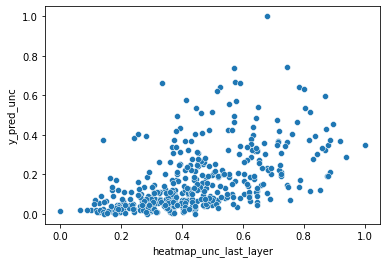

In [15]:
sns.scatterplot(
           x = "heatmap_unc_last_layer",
           y = "y_pred_unc",
            data = res_table)

#### Save Heatmaps, Images and updated Table

In [16]:
if generate_heatmap_and_save:
    res_table.to_csv(DATA_OUTPUT_DIR + "all_tab_results_hm_unc_" + pic_save_name + ".csv",  index=False)
    np.save(DATA_OUTPUT_DIR + "all_heatmaps_" + pic_save_name + ".npy", heatmaps_lc)
    np.save(DATA_OUTPUT_DIR + "all_max_activation_indices_" + pic_save_name + ".npy", max_hm_slices_lc)
    
    if not last_layer_only and hm_type == "gc":
        np.save(DATA_OUTPUT_DIR + "all_heatmaps_average_conv_layer_" + pic_save_name + ".npy", heatmaps_ac)
        np.save(DATA_OUTPUT_DIR + "all_max_activation_indices_laverage_conv_layer_" + pic_save_name + ".npy", max_hm_slices_ac)

## Plot Average Heatmaps

Plot the average heatmaps for all patients. Once for class 0, once for class 1 and once for all patients.

In [17]:
idx = np.where(res_table["y_pred_class"] == 0)

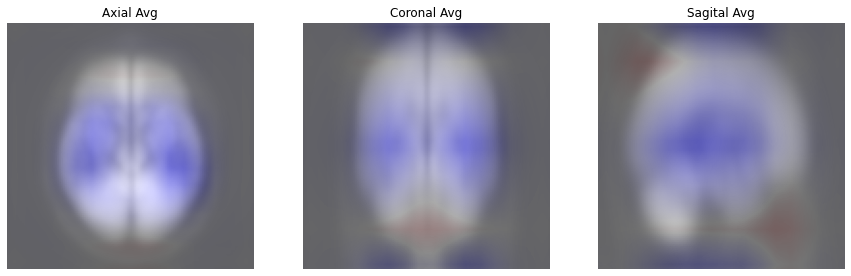

In [18]:
mean_hm_lc = np.array(np.take(heatmaps_lc, idx, axis = 0).squeeze()).mean(axis = 0)
if not last_layer_only:
    mean_hm_ac = np.array(np.take(heatmaps_ac, idx, axis = 0).squeeze()).mean(axis = 0)
mean_image = np.array(np.take(res_images, idx, axis = 0).squeeze()).mean(axis = 0)

phm.plot_heatmap(mean_image, mean_hm_lc,
            version = "overlay",
            mode = "avg",
            hm_colormap = cmap,
            hm_positive = hm_positive)
if not last_layer_only:
    phm.plot_heatmap(mean_image, mean_hm_ac,
                version = "overlay",
                mode = "avg")

In [19]:
idx = np.where(res_table["y_pred_class"] == 1)

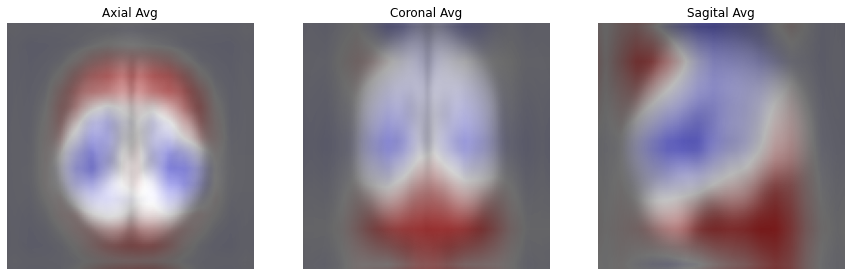

In [20]:
mean_hm_lc = np.array(np.take(heatmaps_lc, idx, axis = 0).squeeze()).mean(axis = 0)
if not last_layer_only:
    mean_hm_ac = np.array(np.take(heatmaps_ac, idx, axis = 0).squeeze()).mean(axis = 0)
mean_image = np.array(np.take(res_images, idx, axis = 0).squeeze()).mean(axis = 0)

phm.plot_heatmap(mean_image, mean_hm_lc,
            version = "overlay",
            mode = "avg",
            hm_colormap = cmap,
            hm_positive = hm_positive)
if not last_layer_only:
    phm.plot_heatmap(mean_image, mean_hm_ac,
                version = "overlay",
                mode = "avg")

In [21]:
idx = np.arange(0,407)

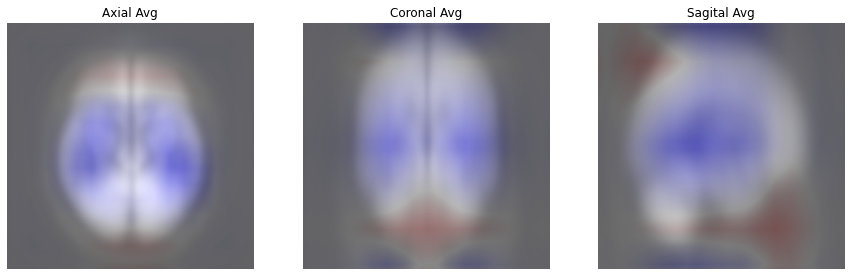

In [22]:
mean_hm_lc = np.array(np.take(heatmaps_lc, idx, axis = 0).squeeze()).mean(axis = 0)
if not last_layer_only:
    mean_hm_ac = np.array(np.take(heatmaps_ac, idx, axis = 0).squeeze()).mean(axis = 0)
mean_image = np.array(np.take(res_images, idx, axis = 0).squeeze()).mean(axis = 0)

phm.plot_heatmap(mean_image, mean_hm_lc,
            version = "overlay",
            mode = "avg",
            hm_colormap = cmap,
            hm_positive = hm_positive)
if not last_layer_only:
    phm.plot_heatmap(mean_image, mean_hm_ac,
                version = "overlay",
                mode = "avg")

## Save Plots as PNG

In [23]:
if generate_pictures:
    if not last_layer_only:
        phm.plot_gradcams_last_avg_org(
            res_table = res_table, 
            vis_layers = vis_layers,
            res_images = res_images,
            res_model_names = res_model_names,
            model_3d = model_3d,
            layer_mode = "mean", 
            heatmap_mode = "avg", 
            save_path = PIC_OUTPUT_DIR, 
            save_name = pic_save_name, save = True)

        phm.plot_gradcams_last_avg_org(
            res_table = res_table, 
            vis_layers = vis_layers,
            res_images = res_images,
            res_model_names = res_model_names,
            model_3d = model_3d,
            layer_mode = "mean",
            heatmap_mode = "max", 
            save_path = PIC_OUTPUT_DIR, 
            save_name = pic_save_name, save = True)
    else:
        phm.plot_heatmaps_avg_max_org(
            pat_data = pat_dat,
            res_table = res_table, 
            res_images = res_images,
            heatmaps = heatmaps_lc,
            cmap = cmap,
            hm_positive = hm_positive,
            save_path = PIC_OUTPUT_DIR, 
            save_name = pic_save_name, save = True)
    


## Save Plots to PDF

In [24]:
# only_wrong_out = True # should already be defined above

In [25]:
if not only_wrong_out: # all ids
    pat_ids = list(res_table["p_id"])
else: # only ids with low uncertainty and wrong classified
    pat_ids = list(res_table.query("pred_correct == False and y_pred_unc < 0.2").p_id)
    res_table[res_table.p_id.isin(pat_ids)].to_csv(
        DATA_OUTPUT_DIR + "all_tab_results_hm_unc_" + pic_save_name + "_wrong_cl.csv",  index=False)

In [26]:
res_table[res_table.p_id.isin(pat_ids)]

,index,p_idx,p_id,mrs,unfavorable,fold0,fold1,fold2,fold3,fold4,...,y_pred_model_4,y_pred_linear_avg,y_pred_trafo_avg,threshold,y_pred_class,y_pred_std,y_pred_unc,pred_correct,heatmap_std_last_layer,heatmap_unc_last_layer
8,247,9,13,2.0,0,train,val,train,train,train,...,0.234019,0.272158,0.270336,0.225491,1,0.047245,0.145727,False,0.104133,0.745412
9,248,10,14,0.0,0,train,val,train,train,train,...,0.565217,0.606532,0.607988,0.225491,1,0.058905,0.185354,False,0.077424,0.480152
28,43,29,39,0.0,0,train,test,train,train,train,...,0.250934,0.292680,0.292006,0.225491,1,0.028454,0.081864,False,0.066393,0.370596
33,3,34,44,1.0,0,test,train,train,train,train,...,0.266245,0.247038,0.246278,0.225491,1,0.025178,0.070731,False,0.105208,0.756091
44,46,45,58,6.0,1,train,test,train,train,train,...,0.126085,0.172998,0.168685,0.225491,0,0.047280,0.145846,False,0.095566,0.660323
75,48,76,109,0.0,0,train,test,train,train,train,...,0.334494,0.344368,0.343566,0.225491,1,0.039773,0.120332,False,0.115064,0.853979
92,259,93,132,0.0,0,train,val,train,train,train,...,0.449849,0.478490,0.478176,0.225491,1,0.055193,0.172738,False,0.108536,0.789136
103,9,104,148,0.0,0,test,train,train,train,train,...,0.205389,0.269342,0.267471,0.225491,1,0.043167,0.131867,False,0.083444,0.539938
119,174,120,169,0.0,0,train,train,train,train,test,...,0.490280,0.444743,0.443928,0.225491,1,0.057872,0.181841,False,0.070523,0.411615
181,99,182,240,1.0,0,train,train,test,train,train,...,0.277462,0.266589,0.262809,0.225491,1,0.059170,0.186253,False,0.081348,0.519125


In [27]:
pdf = FPDF()
pdf.set_auto_page_break(0)

# imagelist is the list with all image filenames
for patient in tqdm(pat_ids):
    
    name_start = PIC_OUTPUT_DIR + "pat" + str(patient) + "_" + pic_save_name
    
    if not last_layer_only:
        pdf.add_page(orientation = "L", format = "A4")
        x,y,w,h = (0,10,160,160)
        pdf.image(name_start + "_last_and_all_layers_avg.png", x,y,w,h)
        x,y,w,h = (140,10,160,160)
        pdf.image(name_start + "_last_and_all_layers_max.png", x,y,w,h)
    else:
        pdf.add_page(orientation = "P", format = "A4")
        x,y,w,h = (0,10,205,205)
        pdf.image(name_start + "_last_layer_avg_max_orig.png", x,y,w,h)
        
    
if only_wrong_out:
    pdf.output(PIC_OUTPUT_DIR + "10Fold_ensembling" + pic_save_name[6:] + "_all_patients_wrong_cl.pdf", "F")
else:
    pdf.output(PIC_OUTPUT_DIR + "10Fold_ensembling" + pic_save_name[6:] + "_all_patients.pdf", "F")


100%|██████████| 25/25 [00:04<00:00,  5.81it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: "dest" parameter is deprecated, unused and will soon be removed
